In [ ]:
# Check GPU
!nvidia-smi


Thu Jul 17 09:24:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import files
uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [6]:
!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [7]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 928MB/s]


In [8]:
!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_data


Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_data/bra

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

IMG_SIZE = 150
data = []
labels = []

# Dataset path
DATA_DIR = '/content/brain_tumor_data/brain_tumor_dataset'

for category in ['yes', 'no']:
    path = os.path.join(DATA_DIR, category)
    label = 1 if category == 'yes' else 0
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except:
            pass

# Convert and normalize
data = np.array(data) / 255.0
data = np.expand_dims(data, axis=-1)
labels = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,635,905 (40.57 MB)

 Trainable params: 10,635,905 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 548ms/step - accuracy: 0.5912 - loss: 1.5432 - val_accuracy: 0.7059 - val_loss: 0.6058
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7726 - loss: 0.5073 - val_accuracy: 0.7647 - val_loss: 0.5496
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8254 - loss: 0.4466 - val_accuracy: 0.7647 - val_loss: 0.5460
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8314 - loss: 0.4054 - val_accuracy: 0.7451 - val_loss: 0.5594
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8870 - loss: 0.2817 - val_accuracy: 0.7255 - val_loss: 0.7855
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9072 - loss: 0.2459 - val_accuracy: 0.8235 - val_loss: 0.4882
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9601 - loss: 0.1346 - val_accuracy: 0.7843 - val_loss: 0.5856
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9892 - loss: 0.0771 - val_accuracy: 0.7843 - val_loss: 0.7221

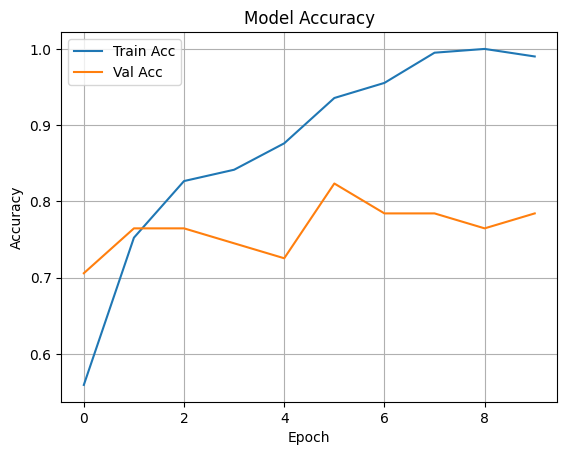

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

# Train using generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7180 - loss: 0.7781 - val_accuracy: 0.7647 - val_loss: 0.6269
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7689 - loss: 0.5269 - val_accuracy: 0.7255 - val_loss: 0.5262
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8014 - loss: 0.4585 - val_accuracy: 0.7843 - val_loss: 0.4971
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7340 - loss: 0.5103 - val_accuracy: 0.7255 - val_loss: 0.5571
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7460 - loss: 0.5123 - val_accuracy: 0.7647 - val_loss: 0.4613
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7338 - loss: 0.5061 - val_accuracy: 0.7451 - val_loss: 0.5580
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7429 - loss: 0.5151 - val_accuracy: 0.7059 - val_loss: 0.6462
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7364 - loss: 0.5453 - val_accuracy: 0.7451 - val_loss: 0.5528
Epoch 9/10


In [14]:
from tensorflow.keras.regularizers import l2

# Example layer with L2
Dense(128, activation='relu', kernel_regularizer=l2(0.001))


<Dense name=dense_2, built=False>

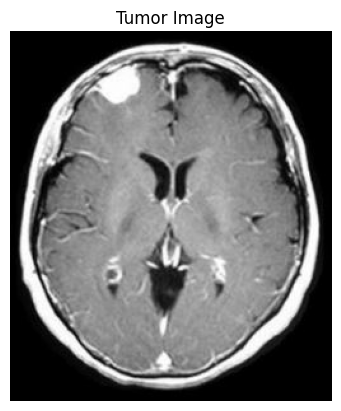

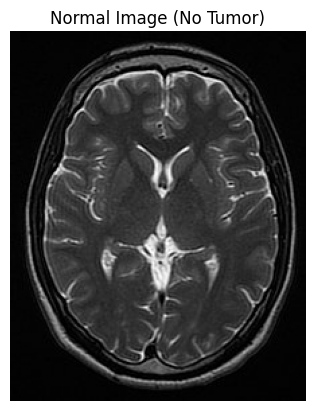

In [15]:
# Show sample images with tumor
import matplotlib.pyplot as plt
import cv2
import os

tumor_path = "/content/brain_tumor_data/brain_tumor_dataset/yes"
normal_path = "/content/brain_tumor_data/brain_tumor_dataset/no"

# Display tumor image
tumor_img = cv2.imread(os.path.join(tumor_path, os.listdir(tumor_path)[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(tumor_img, cmap='gray')
plt.title("Tumor Image")
plt.axis('off')
plt.show()

# Display normal image
normal_img = cv2.imread(os.path.join(normal_path, os.listdir(normal_path)[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(normal_img, cmap='gray')
plt.title("Normal Image (No Tumor)")
plt.axis('off')
plt.show()


In [ ]:
!pip install -q gradio


In [17]:
import gradio as gr
import cv2

def classify_mri(img):
    IMG_SIZE = 150
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0][0]
    label = "🔴 Tumor Detected" if pred > 0.5 else "🟢 No Tumor Detected"
    confidence = f"Confidence: {round(float(pred if pred > 0.5 else 1 - pred)*100, 2)}%"
    return label + "\n" + confidence


In [ ]:
interface = gr.Interface(
    fn=classify_mri,
    inputs=gr.Image(type="numpy", label="Upload Brain MRI"),
    outputs=gr.Textbox(label="Prediction"),
    title="🧠 Brain Tumor Detector",
    description="Upload an MRI image and get instant prediction (Tumor / No Tumor)"
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3fd1d45f1faca2e450.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1702, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
